In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from utils import ftxTransformer, chainlinkTransformer
from trading_utils_simple import checkLongExitSimple,checkShortExitSimple,checkEntrySimple,backtestMoonshotSimple
import time

## Simple Moonshot Strategy on FTX DATA

In [2]:
data = pd.read_csv("ftx_PriceDataETH-PERP_1614906000_1646645961.csv")
hourlyData,weeklyData = ftxTransformer(data)

In [3]:
capital = 100
stables_yield = 0.12
leverage = 8.0
mm_min = 0.0625 #perp protocol 
freq = 7 #weekly

t = time.time()
weeklyData, finalCapital = backtestMoonshotSimple(hourlyData, weeklyData, capital, stables_yield, freq, leverage, mm_min)
elapsed = time.time()-t

#results

print("Trading Alpha  \t : {a:1.3f}".format(a=weeklyData.trading_returns.sum()))
print("Accuracy  \t : {a:2.1f}%".format(a=weeklyData.loc[weeklyData.position * weeklyData.price_change > 0].shape[0]/weeklyData.shape[0]*100))
print("Positive Returns : {a:2.1f}% \n".format(a=weeklyData.loc[weeklyData.trading_returns >= 0].shape[0]/weeklyData.shape[0]*100))

print("Liquidations \t : {a:2.1f}%".format(a=weeklyData.loc[weeklyData.flag=='liquidated'].shape[0]/weeklyData.shape[0]*100))
# print("Stopped Out \t : {a:2.1f}%".format(a=weeklyData.loc[weeklyData.flag=='stop_loss'].shape[0]/weeklyData.shape[0]*100))
print("APY% \t \t : {a:2.1f}%".format(a=(finalCapital-100) / weeklyData.shape[0] *52))
print("Alpha APY% \t : {a:2.1f}%".format(a=(weeklyData.trading_returns.sum()) / weeklyData.shape[0] *52))



Trading Alpha  	 : -0.842
Accuracy  	 : 56.6%
Positive Returns : 47.2% 

Liquidations 	 : 43.4%
APY% 	 	 : 11.3%
Alpha APY% 	 : -0.8%


Text(0.5, 0, 'Time')

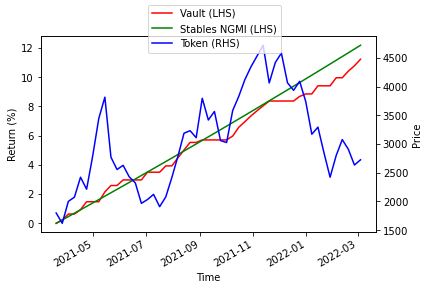

In [4]:
fig = plt.figure()
ax1 = (weeklyData.capital[2:]-100).plot(color = 'red')
(weeklyData.benchmark.shift(2)-100).plot(color ='green') #two week lag in vault returns
ax1.set_ylabel('Return (%)')
plt.twinx()
ax2 = (weeklyData.close[2:]).plot(color ='blue')
ax2.set_ylabel('Price')
fig.legend(['Vault (LHS)','Stables NGMI (LHS)','Token (RHS)'],loc='upper center')
ax1.set_xlabel('Time')

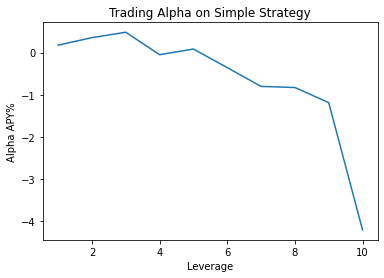

In [5]:
#impact of leverage on unmanaged strategy
capital = 100
stables_yield = 0.12
leverage = 8.0
mm_min = 0.0625 #perp protocol
freq = 7 #weekly

dataStore = pd.DataFrame()

for leverage in range(1,11):
    out, finalCapital = backtestMoonshotSimple(hourlyData, weeklyData, capital, stables_yield, freq, leverage, mm_min)
    alphaAPY = (out.trading_returns.sum()) / out.shape[0] *52
    
    dataStore = pd.concat([dataStore, pd.DataFrame({"Alpha":[alphaAPY]},index=[leverage])])
    
    
plt.plot(dataStore)
plt.xlabel("Leverage")
plt.ylabel("Alpha APY%")
plt.title("Trading Alpha on Simple Strategy")
plt.show()